Fixing missing blocks is a known issue between one census and another

In [ ]:
%matplotlib inline

# Assuming we are in the notebooks directory, we need to move one up:
%cd ..

from __future__ import division

import os
import us
import requests

import pandas as pd
import geopandas as gpd

from secret import *
from default_values import *

In [2]:
state = u'arizona'
state_fips = us.states.lookup(state).fips
state_fips

u'04'

In [3]:
# try:
if True:
    print 'Attempting to load predicted population by block for:', state
#     df = gpd.read_file(blocks_geojson_filename)
# except IOError:
    print '\tNot found on disk...'
    print '\tDownloading and processing blocks and block groups for:', state
    # Open 2010 blocks for state (the population):
    print '\tOpening 2010 blocks shapefile for:', state
    blocks_2010_shapefile_name = blocks_2010_shapefile_dir + 'tabblock2010_' +\
        state_fips + '_pophu.shp'
    blocks_df = gpd.read_file(blocks_2010_shapefile_name)
    blocks_df['BLOCKID10'] = blocks_df['BLOCKID10'].apply(str)
    def get_group_GEOID(blockGEOID):
        return blockGEOID[0:-3]
    blocks_df['Block Group GEOID'] = blocks_df['BLOCKID10'].apply(get_group_GEOID)
    assert (blocks_df['Block Group GEOID'].apply(len)).unique() == [12]
    # The filename for the whole state with block groups (without population):
    print '\tOpening ACS5 block groups shapefile for:', state
    block_groups_shapefile_name = acs5_shapefile_dir + 'tl_' + year + '_' +\
        state_fips + '_bg.shp'
    block_groups_df = gpd.read_file(block_groups_shapefile_name)
    # We will add to this the population per block group from the API.
    # Check GEOIDs are of length 12 because they have to be by definition,
    # see: https://www.census.gov/geo/reference/geoidentifiers.html
    assert (block_groups_df['GEOID'].apply(len)).unique() == [12]
  
    
    
    print set(block_groups_df['GEOID'].unique()).symmetric_difference(set(
        blocks_df['Block Group GEOID'].unique()))
        # ['060378002043', '060379304011', u'060371370002', u'060371370001']

Attempting to load predicted population by block for: arizona
	Not found on disk...
	Opening 2010 blocks shapefile for: arizona
	Opening ACS5 block groups shapefile for: arizona
set([u'040190041211', u'040190027042', u'040190052001', u'040190052003', u'040190052002', u'040190052004', '040194705001', '040194705002', '040190029031', '040194704004', '040194704003', '040194704002', '040194704001', u'040190041251', u'040190041252', u'040190053001', u'040190053002', u'040190041181', '040194105021', u'040190027041', '040194105032', '040194105031', u'040190029061', '040194105011', '040190027012', '040190027011'])


In [4]:
diff = list(set(block_groups_df['GEOID'].unique()).symmetric_difference(set(
         blocks_df['Block Group GEOID'].unique())))
len(diff)

26

In [5]:
for d in diff:
    if d in blocks_df['Block Group GEOID'].values:
        print d

040194705001
040194705002
040190029031
040194704004
040194704003
040194704002
040194704001
040194105021
040194105032
040194105031
040194105011
040190027012
040190027011


In [6]:
#These are the block groups that get lost:
for i, d in enumerate(diff):
#     print i
#     d = str(d)
#     print block_groups_df[block_groups_df['GEOID'].astype(str).str.contains(d)]
    try:
        lost_block_groups = pd.concat([lost_block_groups,
                                      block_groups_df[block_groups_df['GEOID'].astype(str).str.contains(d)]])
    except NameError:
        lost_block_groups = block_groups_df[block_groups_df['GEOID'].astype(str).str.contains(d)]
lost_block_groups.shape

(13, 13)

In [7]:
lost_block_groups

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,TRACTCE,geometry
3889,59587573,0,1,019,S,040190041211,+32.1037569,-110.9114028,G5030,Block Group 1,04,004121,"POLYGON ((-110.961019 32.134011, -110.960754 3..."
3859,332386,0,2,019,S,040190027042,+32.2740185,-110.9480972,G5030,Block Group 2,04,002704,"POLYGON ((-110.952409 32.274524, -110.952399 3..."
3207,1221227,0,1,019,S,040190052001,+32.3820249,-112.8683028,G5030,Block Group 1,04,005200,"POLYGON ((-112.872444 32.376241, -112.872443 3..."
3208,1332426,0,3,019,S,040190052003,+32.3814626,-112.8607085,G5030,Block Group 3,04,005200,"POLYGON ((-112.865805 32.385519, -112.865436 3..."
3885,3971990528,0,2,019,S,040190052002,+32.2164845,-112.9778332,G5030,Block Group 2,04,005200,"POLYGON ((-113.334104 32.189539, -113.334077 3..."
3209,1370254,0,4,019,S,040190052004,+32.3817937,-112.8765515,G5030,Block Group 4,04,005200,"POLYGON ((-112.883422 32.38919, -112.883415 32..."
3165,10635667,0,1,019,S,040190041251,+32.0881765,-110.8390669,G5030,Block Group 1,04,004125,"POLYGON ((-110.85796 32.07911, -110.857961 32...."
3171,1619398,0,2,019,S,040190041252,+32.0947600,-110.8336506,G5030,Block Group 2,04,004125,"POLYGON ((-110.841083 32.095689, -110.841081 3..."
3210,4697117,0,1,019,S,040190053001,+32.2421919,-110.7725334,G5030,Block Group 1,04,005300,"POLYGON ((-110.79847 32.243267, -110.798386 32..."
3945,13853669,0,2,019,S,040190053002,+32.2431818,-110.7125097,G5030,Block Group 2,04,005300,"POLYGON ((-110.755649 32.236415, -110.755647 3..."


In [13]:
    print len(set(block_groups_df['GEOID'].unique()).difference(set(
        blocks_df['Block Group GEOID'].unique())))


13


In [14]:
    print len(set(
         blocks_df['Block Group GEOID'].unique()).difference(set(block_groups_df['GEOID'].unique())))

13


In [15]:
    print blocks_df[blocks_df['Block Group GEOID'] == '040194705002']['POP10']


190245    221
190610     22
192095     11
193216    160
193218     48
193221     15
195583    340
195644     78
195648      7
199357      5
199534    191
200082     75
200550    127
200620     26
200833      0
203154     43
203156     95
204805      9
205530     76
205563    102
205565     68
205595     55
205597     65
206919    192
Name: POP10, dtype: int64


In [16]:
    print blocks_df[blocks_df['Block Group GEOID'] == '060371370001']['POP10']

Series([], Name: POP10, dtype: int64)


In [17]:
        # Code to get the total estimated population from the census files:
        api_population = 'B01003_001E'  # http://api.census.gov/data/2015/acs5/variables.html
        # NB: this is not the same code in the shapefiles for each block from the 2010
        # census, which instead uses 'POP10'.
        # Get all the counties' IDs so we can d/l each county's population per
        # block group:
        def block_group_to_county_geoid(geoid):
            return geoid[2:5]
        block_groups_df['County'] = block_groups_df['GEOID'].apply(block_group_to_county_geoid)
        block_groups_for_state = acs5_population_dir + state + '.json'
        try:
            print '\tAttempting to load ACS5 population for block groups by county for:', state
            with open(block_groups_for_state, 'r') as infile:
                population_df = pd.read_json(infile)
        except IOError:
            print '\t\tNot found on disk...'
            counties = block_groups_df['County'].unique()
            for county in counties:
                print '\t\tDownloading block groups for county:', county
                url = 'http://api.census.gov/data/' + year + '/acs5?get=NAME,' +\
                    api_population + '&for=block+group:*&in=state:' + \
                    state_fips + '+county:' + county + '&key=' + apikey
                # Make a get request to get the population of each county per block
                # group:
                response = requests.get(url)
                try:
                    data = response.json()
                except ValueError:  # includes simplejson.decoder.JSONDecodeError
                    # This is what happens when the server times out etc.
                    print 'Decoding JSON has failed. Server response:',\
                        response.status_code
                    exit()
                # Merge the df to get one huge df for the whole state which contains
                # all the group blocks and their populations:
                columns = data.pop(0) # columns as list and leaves data intact
                try:
                    # Try appending to previous population_df:
                    population_df = population_df.append(
                        pd.DataFrame(data, columns=columns),
                        ignore_index=True)
                except NameError:
                    # There is no previous, so create it:
                    population_df = pd.DataFrame(data, columns=columns)
            population_df.to_json(block_groups_for_state)
        print '\tDone!'

	Attempting to load ACS5 population for block groups by county for: arizona
	Done!


In [18]:
    def create_geoid(row):
        # GEOID Structure is defined as STATE + COUNTY + TRACT + BLOCK GROUP =
        # 2 + 3 + 6 + 1 = 12
        # see: https://www.census.gov/geo/reference/geoidentifiers.html
        STATE = str(row['state']).zfill(2)  # zero padding to conform to GEOID
        COUNTY = str(row['county']).zfill(3)
        TRACT = str(row['tract']).zfill(6)
        BLOCK_GROUP = str(row['block group'])
        assert len(STATE + COUNTY + TRACT + BLOCK_GROUP) == 12
        return STATE + COUNTY + TRACT + BLOCK_GROUP
    population_df['GEOID'] = population_df.apply(create_geoid, axis=1)
    
    

In [19]:
block_groups_df.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,TRACTCE,geometry,County
0,666349,0,3,013,S,040135230023,+33.3097028,-111.8546715,G5030,Block Group 3,04,523002,"POLYGON ((-111.859104 33.307374, -111.85908 33...",013
1,953890,0,3,013,S,040135231023,+33.2952931,-111.8306239,G5030,Block Group 3,04,523102,"POLYGON ((-111.837021 33.298904, -111.836559 3...",013
2,379597,0,2,019,S,040190025042,+32.1710784,-111.0002109,G5030,Block Group 2,04,002504,"POLYGON ((-111.004891 32.169707, -111.004839 3...",019
3,412197,0,1,019,S,040190025051,+32.1510298,-111.0021486,G5030,Block Group 1,04,002505,"POLYGON ((-111.006683 32.149475, -111.006653 3...",019
4,595584,0,1,019,S,040190025061,+32.1427262,-111.0089917,G5030,Block Group 1,04,002506,"POLYGON ((-111.011674 32.140608, -111.011629 3...",019


In [20]:
    block_groups_df = block_groups_df.merge(population_df, on='GEOID')
    assert block_groups_df['GEOID'].shape == population_df['GEOID'].shape
#     del population_df
    # Get rid of other columns, we are just interested in below for each block
    # group:
    block_groups_df = block_groups_df.loc[:,['GEOID',api_population]]
    # We need to calculate the proportion of the populalion of 2010 block group
    # that a constituent 2010 block has:
    # a. get the total population for each block group from 2010 and associate
    # each 2010 block with its total:
    blocks_df['POP10'] = pd.to_numeric(blocks_df['POP10'])
    blocks_df = blocks_df.join(blocks_df.groupby('Block Group GEOID')[
                               'POP10'].sum(), on='Block Group GEOID',
                                rsuffix=' for 2010 Block Group')
    blocks_df.rename(columns={'POP10 for 2010 Block Group':\
                              'Population for 2010 Block Group'}, inplace=True)

In [21]:
blocks_df.head()

,BLOCKCE,BLOCKID10,COUNTYFP10,HOUSING10,PARTFLG,POP10,STATEFP10,TRACTCE10,geometry,Block Group GEOID,Population for 2010 Block Group
0,1059,040270111071059,027,0,N,0,04,011107,"POLYGON ((-114.574787 32.658824, -114.574627 3...",040270111071,239
1,2002,040270111072002,027,0,N,0,04,011107,"POLYGON ((-114.572568 32.647748, -114.572562 3...",040270111072,1228
2,2045,040270111072045,027,0,N,0,04,011107,"POLYGON ((-114.572483 32.639727, -114.572693 3...",040270111072,1228
3,1437,040270121001437,027,0,N,0,04,012100,"POLYGON ((-114.438835 32.862745, -114.4395 32....",040270121001,571
4,2037,040270109142037,027,0,N,0,04,010914,"POLYGON ((-114.522074 32.753558, -114.522062 3...",040270109142,498


In [22]:

# b. get the ratio of block population to respective block group
# population:
def calculate_ratio(row):
    try:
        return row['POP10'] / row['Population for 2010 Block Group']
    except:
        return row['Population for 2010 Block Group']
blocks_df['Population Ratio'] = blocks_df.apply(calculate_ratio, axis=1)
# c. get the population for the 2015 ACS5 block groups and associate them
# with their respective blocks:
blocks_df = pd.merge(blocks_df, block_groups_df,
                     left_on = 'Block Group GEOID',
                     right_on = 'GEOID')
blocks_df.rename(columns={api_population:\
                    'Population for ' + year + ' Block Group'},
                 inplace=True)
assert (blocks_df['GEOID'] == blocks_df['Block Group GEOID']).all()
del blocks_df['GEOID']
blocks_df['Population for ' + year + ' Block Group'] =\
    pd.to_numeric(blocks_df['Population for ' + year + ' Block Group'])
assert block_groups_df[api_population].sum() > blocks_df['POP10'].sum()
# assert blocks_df['Population for 2010 Block Group'].sum() <\
    # blocks_df['Population for ' + year + ' Block Group'].sum()
#     del block_groups_df # we do not need this anymore
# d. calculate the predicted population for the block based on the above:
blocks_df[population] = blocks_df['Population Ratio'] *\
    blocks_df['Population for ' + year + ' Block Group']
# Calculate the centroids for each block required for clustering:
def get_x(p): return p.x
def get_y(p): return p.y
blocks_df['Centroid Longitude'] = blocks_df['geometry'].centroid.apply(get_x)
blocks_df['Centroid Latitude'] = blocks_df['geometry'].centroid.apply(get_y)
# Find which congressional district each block group for this state belongs
#  to. This is done using the block assignments files downloaded from:
#  https://www.census.gov/geo/maps-data/data/baf.html
# print '\tCalculating congressional districts for:', state
block_assignments_df = pd.read_csv(block_assignments_dir +\
    'National_CD115.txt', dtype={"BLOCKID": str, "CD115": str})
block_assignments_df.rename(columns={'BLOCKID': 'GEOID'}, inplace=True)
blocks_df.rename(columns={'BLOCKID10': 'GEOID'}, inplace=True)
blocks_df = blocks_df.merge(block_assignments_df, how='left',
    indicator=True)
assert blocks_df['_merge'].unique() == ['both']
del blocks_df['_merge']
del block_assignments_df
# We are done now, check that columns are what we expect before we remove
# useless ones:
assert list(blocks_df) ==\
    [u'BLOCKCE', 'GEOID', u'COUNTYFP10', u'HOUSING10', u'PARTFLG', u'POP10',
     u'STATEFP10', u'TRACTCE10', 'geometry', 'Block Group GEOID',
     'Population for 2010 Block Group', 'Population Ratio',
     'Population for 2015 Block Group', 'Predicted 2015 Population',
     'Centroid Longitude', 'Centroid Latitude', 'CD115']


In [23]:
blocks_df.head()

,BLOCKCE,GEOID,COUNTYFP10,HOUSING10,PARTFLG,POP10,STATEFP10,TRACTCE10,geometry,Block Group GEOID,Population for 2010 Block Group,Population Ratio,Population for 2015 Block Group,Predicted 2015 Population,Centroid Longitude,Centroid Latitude,CD115
0,1059,040270111071059,027,0,N,0,04,011107,"POLYGON ((-114.574787 32.658824, -114.574627 3...",040270111071,239,0.0,440,0.0,-114.573730,32.656864,04
1,1017,040270111071017,027,0,N,0,04,011107,"POLYGON ((-114.55146 32.676974, -114.553424 32...",040270111071,239,0.0,440,0.0,-114.558543,32.680474,04
2,1011,040270111071011,027,0,N,0,04,011107,"POLYGON ((-114.572876 32.682073, -114.572874 3...",040270111071,239,0.0,440,0.0,-114.578089,32.683058,04
3,1078,040270111071078,027,0,N,0,04,011107,"POLYGON ((-114.572764 32.667908, -114.572776 3...",040270111071,239,0.0,440,0.0,-114.572710,32.668830,04
4,1080,040270111071080,027,0,N,0,04,011107,"POLYGON ((-114.574997 32.669982, -114.572837 3...",040270111071,239,0.0,440,0.0,-114.573902,32.669853,04


In [24]:
lost_block_groups.head()

,ALAND,AWATER,BLKGRPCE,COUNTYFP,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,MTFCC,NAMELSAD,STATEFP,TRACTCE,geometry
3889,59587573,0,1,019,S,040190041211,+32.1037569,-110.9114028,G5030,Block Group 1,04,004121,"POLYGON ((-110.961019 32.134011, -110.960754 3..."
3859,332386,0,2,019,S,040190027042,+32.2740185,-110.9480972,G5030,Block Group 2,04,002704,"POLYGON ((-110.952409 32.274524, -110.952399 3..."
3207,1221227,0,1,019,S,040190052001,+32.3820249,-112.8683028,G5030,Block Group 1,04,005200,"POLYGON ((-112.872444 32.376241, -112.872443 3..."
3208,1332426,0,3,019,S,040190052003,+32.3814626,-112.8607085,G5030,Block Group 3,04,005200,"POLYGON ((-112.865805 32.385519, -112.865436 3..."
3885,3971990528,0,2,019,S,040190052002,+32.2164845,-112.9778332,G5030,Block Group 2,04,005200,"POLYGON ((-113.334104 32.189539, -113.334077 3..."


In [25]:

    # Get rid of colums we do not need:
blocks_df = blocks_df.loc[:,['GEOID', 'CD115', 'geometry',
                                 'Predicted 2015 Population',
                                 'Centroid Longitude', 'Centroid Latitude']]

In [26]:
blocks_df.head()

,GEOID,CD115,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
0,040270111071059,04,"POLYGON ((-114.574787 32.658824, -114.574627 3...",0.0,-114.573730,32.656864
1,040270111071017,04,"POLYGON ((-114.55146 32.676974, -114.553424 32...",0.0,-114.558543,32.680474
2,040270111071011,04,"POLYGON ((-114.572876 32.682073, -114.572874 3...",0.0,-114.578089,32.683058
3,040270111071078,04,"POLYGON ((-114.572764 32.667908, -114.572776 3...",0.0,-114.572710,32.668830
4,040270111071080,04,"POLYGON ((-114.574997 32.669982, -114.572837 3...",0.0,-114.573902,32.669853


In [27]:

# Give columns better names:
blocks_df.rename(columns={'CD115': 'Congressional District',
                          'Centroid Longitude': 'Centroid Longitude',
                          'Centroid Latitude': 'Centroid Latitude'},
                  inplace=True)
blocks_df['Congressional District'] = blocks_df['Congressional District'].apply(str)
blocks_df['Centroid Longitude'] = blocks_df['Centroid Longitude'].apply(float)
blocks_df['Centroid Latitude'] = blocks_df['Centroid Latitude'].apply(float)
blocks_df['Predicted 2015 Population'] = blocks_df['Predicted 2015 Population'].apply(float)
# We are finally done, save the file!
print 'Saving file...'
blocks_df = gpd.GeoDataFrame(blocks_df)
with open(blocks_geojson_filename, 'w') as outfile:
    outfile.write(blocks_df.to_json())
# In the rest of this code the block-wise dataframe with predicted
# populations is called just df:
df = blocks_df
del blocks_df
print 'Done!'

Saving file...
Done!


In [28]:
# del lost_block_groups['ALAND']
# del lost_block_groups['AWATER']
# del lost_block_groups['BLKGRPCE']

population_df.head()
lost_block_groups = lost_block_groups.merge(population_df, on='GEOID')

In [29]:
lost_block_groups.head()
lost_block_groups['Centroid Longitude'] = lost_block_groups['geometry'].centroid.apply(get_x)
    
lost_block_groups['Centroid Latitude'] = lost_block_groups['geometry'].centroid.apply(get_y)

In [30]:
lost_block_groups.rename(columns={'B01003_001E': 'Predicted 2015 Population'}, inplace=True)

lost_block_groups = lost_block_groups[['GEOID', 'geometry', 'Predicted 2015 Population', 'Centroid Longitude', 'Centroid Latitude']]
lost_block_groups.head()


,GEOID,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
0,040190041211,"POLYGON ((-110.961019 32.134011, -110.960754 3...",8335,-110.911404,32.103756
1,040190027042,"POLYGON ((-110.952409 32.274524, -110.952399 3...",677,-110.948097,32.274019
2,040190052001,"POLYGON ((-112.872444 32.376241, -112.872443 3...",1431,-112.868303,32.382025
3,040190052003,"POLYGON ((-112.865805 32.385519, -112.865436 3...",657,-112.860708,32.381463
4,040190052002,"POLYGON ((-113.334104 32.189539, -113.334077 3...",1355,-112.977957,32.216672


In [31]:
df.tail()

,GEOID,Congressional District,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
240544,040250004013004,04,"POLYGON ((-112.481644 34.582144, -112.481583 3...",87.626230,-112.479086,34.581870
240545,040250004013002,04,"POLYGON ((-112.476733 34.577961, -112.476793 3...",91.849180,-112.474001,34.581774
240546,040250004013000,04,"POLYGON ((-112.467555 34.587933, -112.467643 3...",91.321311,-112.470467,34.588050
240547,040250004013001,04,"POLYGON ((-112.476358 34.587679, -112.476217 3...",46.980328,-112.474215,34.586672
240548,040250004013003,04,"POLYGON ((-112.47652 34.579624, -112.476564 34...",4.222951,-112.475585,34.579835


In [32]:
block_groups_df.head()

,GEOID,B01003_001E
0,040135230023,1387
1,040135231023,1602
2,040190025042,1159
3,040190025051,1669
4,040190025061,1862


In [35]:
usa = gpd.read_file(usa_shapefile_path)
cong_dist = usa[usa['STATEFP'].apply(
    int) == int(state_fips)]
del usa

In [36]:
cong_dist.head()

,ALAND,AWATER,CD115FP,CDSESSN,FUNCSTAT,GEOID,INTPTLAT,INTPTLON,LSAD,MTFCC,NAMELSAD,STATEFP,geometry
8,142545957897,354073634,01,115,N,0401,+34.9710133,-110.7259249,C2,G5200,Congressional District 1,04,"POLYGON ((-114.042377 35.72514, -114.041594 35..."
51,20298522803,138380234,02,115,N,0402,+31.9166176,-109.9387277,C2,G5200,Congressional District 2,04,"POLYGON ((-111.093531 31.870879, -111.092155 3..."
94,40632449010,8411270,03,115,N,0403,+32.4238155,-112.4025904,C2,G5200,Congressional District 3,04,"POLYGON ((-114.816591 32.507696, -114.816294 3..."
132,85987707443,504272377,04,115,N,0404,+34.5909175,-113.2045275,C2,G5200,Congressional District 4,04,"POLYGON ((-114.754508 36.086171, -114.753784 3..."
167,760077551,2290755,05,115,N,0405,+33.3397081,-111.7124518,C2,G5200,Congressional District 5,04,"POLYGON ((-111.893596 33.291148, -111.892619 3..."


In [37]:
missing_bg_cong_dist = pd.DataFrame(columns=[['GEOID', 'Congressional District']])
missing_bg_cong_dist.head()

,GEOID,Congressional District


In [38]:
geoid = []
cd = []
for bg_index, bg_row in lost_block_groups.iterrows():
    for dist_index, dist_row in cong_dist.iterrows():
        bg_area =  bg_row['geometry'].area
        intersection_area = bg_row['geometry'].intersection(dist_row['geometry']).area
        if bg_area - intersection_area < 1e-10:
#             print bg_index, dist_row['CD115FP']
#             print intersection_area, bg_area
            geoid.append(bg_row['GEOID'])
            cd.append(dist_row['CD115FP'])
        
geoid, cd

([u'040190041211',
  u'040190027042',
  u'040190052001',
  u'040190052003',
  u'040190052002',
  u'040190052004',
  u'040190041251',
  u'040190041252',
  u'040190053001',
  u'040190053002',
  u'040190027041',
  u'040190029061'],
 [u'03',
  u'02',
  u'03',
  u'03',
  u'03',
  u'03',
  u'02',
  u'02',
  u'02',
  u'02',
  u'02',
  u'02'])

In [39]:
missing_bg_cong_dist['GEOID'] = geoid
missing_bg_cong_dist['Congressional District'] = cd
missing_bg_cong_dist.head()

,GEOID,Congressional District
0,040190041211,03
1,040190027042,02
2,040190052001,03
3,040190052003,03
4,040190052002,03


In [40]:
lost_block_groups = lost_block_groups.merge(missing_bg_cong_dist, on = 'GEOID')
# del lost_block_groups['Congressional District_x']
# del lost_block_groups['Congressional District_y']

In [41]:
lost_block_groups.tail()


,GEOID,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude,Congressional District
7,040190041252,"POLYGON ((-110.841083 32.095689, -110.841081 3...",2129,-110.833651,32.094760,02
8,040190053001,"POLYGON ((-110.79847 32.243267, -110.798386 32...",1156,-110.772533,32.242192,02
9,040190053002,"POLYGON ((-110.755649 32.236415, -110.755647 3...",2402,-110.712510,32.243180,02
10,040190027041,"POLYGON ((-110.952432 32.283423, -110.952431 3...",1240,-110.948300,32.281089,02
11,040190029061,"POLYGON ((-110.901107 32.275107, -110.899302 3...",2306,-110.889042,32.266571,02


In [42]:
df.head()

,GEOID,Congressional District,geometry,Predicted 2015 Population,Centroid Longitude,Centroid Latitude
0,040270111071059,04,"POLYGON ((-114.574787 32.658824, -114.574627 3...",0.0,-114.573730,32.656864
1,040270111071017,04,"POLYGON ((-114.55146 32.676974, -114.553424 32...",0.0,-114.558543,32.680474
2,040270111071011,04,"POLYGON ((-114.572876 32.682073, -114.572874 3...",0.0,-114.578089,32.683058
3,040270111071078,04,"POLYGON ((-114.572764 32.667908, -114.572776 3...",0.0,-114.572710,32.668830
4,040270111071080,04,"POLYGON ((-114.574997 32.669982, -114.572837 3...",0.0,-114.573902,32.669853


In [43]:
df.shape
df = df.append(lost_block_groups, ignore_index=True)
df.shape

(240561, 6)

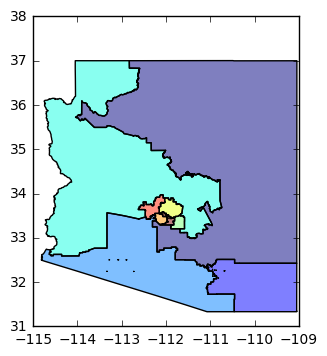

In [44]:
df.dissolve(by='Congressional District').plot()

In [45]:
with open(prediction_geojson_dir+'AZ.geojson', 'w') as outfile:
    outfile.write(df.to_json())